In [1]:
#! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
# then restart kernel 

In [2]:
import numpy as np
import pandas as pd
import glob
import os
import re
#from google.colab import files


def load_games():
  seasons = ['15-16.csv','16-17.csv','17-18.csv','18-19.csv','19-20.csv']   #in case of google colab use files.upload()
  dfs = []

  for filename in seasons:

    dfs.append(pd.read_csv(filename, encoding='utf8', names=['Home team', 'Away team', 'Board no. ', 'Title home', 'Elo home',
                                                          'Player home','Color home', 'Result', 'Color away',
                                                          'Player away','Elo away','Title away', 'Date', 'Time', 'League', 'Round', 'Season']) )

  #Concatenate all data into one DataFrame

  all_games = pd.concat(dfs, ignore_index=True)
  return all_games


df = load_games()
df.head()

,Home team,Away team,Board no.,Title home,Elo home,Player home,Color home,Result,Color away,Player away,Elo away,Title away,Date,Time,League,Round,Season
0,HÜSI SC,HVSE-Infraplan,1,IM,2374,Böröcz István,black,01,white,Jankovic Alojzije,2557,GM,2015-11-07,15:00,nb1,0,15-16
1,HÜSI SC,HVSE-Infraplan,2,NaN,2362,Havasi Gergő,white,½½,black,Ruck Róbert,2565,GM,2015-11-07,15:00,nb1,0,15-16
2,HÜSI SC,HVSE-Infraplan,3,GM,2470,Kosic Dragan,black,½½,white,Németh Miklós,2469,IM,2015-11-07,15:00,nb1,0,15-16
3,HÜSI SC,HVSE-Infraplan,4,IM,2424,Stankovic Milos,white,½½,black,Dr. Kovács Gábor,2462,IM,2015-11-07,15:00,nb1,0,15-16
4,HÜSI SC,HVSE-Infraplan,5,GM,2426,Drazic Sinisa,black,½½,white,Mészáros Michal,2389,IM,2015-11-07,15:00,nb1,0,15-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27975,Cs1,Cs2,2,NaN,2100,Kovács Apollón,white,10\r\n,black,Elek Mónika,1869,NaN,2020-09-13,10:00,nb2toth,8,19-20
27976,Cs1,Cs2,1,NaN,2118,Károlyfalvi Zoltán,black,\r\n10,white,Markó Árpád,1948,NaN,2020-09-13,10:00,nb2toth,8,19-20
27977,Cs1,Cs2,2,NaN,2100,Kovács Apollón,white,10\r\n,black,Elek Mónika,1869,NaN,2020-09-13,10:00,nb2toth,8,19-20
27978,Cs1,Cs2,1,NaN,2118,Károlyfalvi Zoltán,black,\r\n10,white,Markó Árpád,1948,NaN,2020-09-13,10:00,nb2toth,8,19-20


In [3]:
def correct_round(df):
  
  df['Round'] = df['Round'].apply(np.int64 )
  
  return df

df = correct_round(df)
df

def drop_no_team_row(df):
  
  df.drop(df[(df['Home team'] == 'Cs1') | (df['Home team'] == 'Cs2')].index, inplace=True)
  df.reset_index()

  return df


def convert_result(df):
    
    df['Result_home'] = df['Result'].apply(lambda x: 0 if x == '01' else (0.5 if x == '½½' else 1))
    df['Result_away'] = df['Result'].apply(lambda x: 1 if x == '01' else (0.5 if x == '½½' else 0))

    del df['Result']
    
    df.reindex(df.columns, axis=1)
    
    return df

df = drop_no_team_row(df)
df = convert_result(df)
df.head()

,Home team,Away team,Board no.,Title home,Elo home,Player home,Color home,Color away,Player away,Elo away,Title away,Date,Time,League,Round,Season,Result_home,Result_away
0,HÜSI SC,HVSE-Infraplan,1,IM,2374,Böröcz István,black,white,Jankovic Alojzije,2557,GM,2015-11-07,15:00,nb1,0,15-16,0.0,1.0
1,HÜSI SC,HVSE-Infraplan,2,NaN,2362,Havasi Gergő,white,black,Ruck Róbert,2565,GM,2015-11-07,15:00,nb1,0,15-16,0.5,0.5
2,HÜSI SC,HVSE-Infraplan,3,GM,2470,Kosic Dragan,black,white,Németh Miklós,2469,IM,2015-11-07,15:00,nb1,0,15-16,0.5,0.5
3,HÜSI SC,HVSE-Infraplan,4,IM,2424,Stankovic Milos,white,black,Dr. Kovács Gábor,2462,IM,2015-11-07,15:00,nb1,0,15-16,0.5,0.5
4,HÜSI SC,HVSE-Infraplan,5,GM,2426,Drazic Sinisa,black,white,Mészáros Michal,2389,IM,2015-11-07,15:00,nb1,0,15-16,0.5,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27955,Félegyháza-Csongrád,Gyulai SE,8,NaN,1924,Kelemen Sándor,white,black,Oltean Cristian-Daniel,1911,NaN,2020-03-08,10:00,nb2toth,6,19-20,0.0,1.0
27956,Félegyháza-Csongrád,Gyulai SE,9,NaN,1943,Szekeres Sebestyén,black,white,Györgydeák Tibor,1766,NaN,2020-03-08,10:00,nb2toth,6,19-20,0.5,0.5
27957,Félegyháza-Csongrád,Gyulai SE,10,NaN,1738,Hideg Ferenc Bendegúz,white,black,Gurzó Bence Bendeguz,1571,NaN,2020-03-08,10:00,nb2toth,6,19-20,0.5,0.5
27958,Félegyháza-Csongrád,Gyulai SE,11,NaN,1590,Nagy Noémi,black,white,Vaszkó Szabolcs,NaN,-,2020-03-08,10:00,nb2toth,6,19-20,1.0,0.0


In [4]:
%%time

def correct_columns(df):
  #df1 = df.copy()
  
  #df.loc['Elo home'] = df['Elo home'].str.replace(r'\D+','1400')
  df.loc[:,'Elo home'] = df['Elo home'].str.extract('(\d+)', expand=False)
  df.loc[:,'Elo home'] = df['Elo home'].fillna(1400)
  
  df.loc[:,'Elo away'] = df['Elo away'].str.extract('(\d+)', expand=False)
  df.loc[:,'Elo away'] = df['Elo away'].fillna(1400)

  df.loc[:,'Title home'] = df['Title home'].apply(lambda x: 'No Title' if pd.isnull(x) else x)
  df.loc[:,'Title away'] = df['Title away'].apply(lambda x: 'No Title' if pd.isnull(x) else x ) 

  df.loc[:,'Color home'] = df['Color home'].apply(lambda x: 0 if x == 'white' else 1)
  df.loc[:,'Color away'] = df['Color away'].apply(lambda x: 0 if x == 'white' else 1)

  df.loc[:,'Time'] = df['Time'].str[0:2]+':00'
    
  df.loc[:,'Elo diff'] = df['Elo home'].astype(float) - df['Elo away'].astype(float)

    
  return df 


df = correct_columns(df)
df.head()

Wall time: 489 ms


,Home team,Away team,Board no.,Title home,Elo home,Player home,Color home,Color away,Player away,Elo away,Title away,Date,Time,League,Round,Season,Result_home,Result_away,Elo diff
0,HÜSI SC,HVSE-Infraplan,1,IM,2374,Böröcz István,1,0,Jankovic Alojzije,2557,GM,2015-11-07,15:00,nb1,0,15-16,0.0,1.0,-183.0
1,HÜSI SC,HVSE-Infraplan,2,No Title,2362,Havasi Gergő,0,1,Ruck Róbert,2565,GM,2015-11-07,15:00,nb1,0,15-16,0.5,0.5,-203.0
2,HÜSI SC,HVSE-Infraplan,3,GM,2470,Kosic Dragan,1,0,Németh Miklós,2469,IM,2015-11-07,15:00,nb1,0,15-16,0.5,0.5,1.0
3,HÜSI SC,HVSE-Infraplan,4,IM,2424,Stankovic Milos,0,1,Dr. Kovács Gábor,2462,IM,2015-11-07,15:00,nb1,0,15-16,0.5,0.5,-38.0
4,HÜSI SC,HVSE-Infraplan,5,GM,2426,Drazic Sinisa,1,0,Mészáros Michal,2389,IM,2015-11-07,15:00,nb1,0,15-16,0.5,0.5,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27955,Félegyháza-Csongrád,Gyulai SE,8,No Title,1924,Kelemen Sándor,0,1,Oltean Cristian-Daniel,1911,No Title,2020-03-08,10:00,nb2toth,6,19-20,0.0,1.0,13.0
27956,Félegyháza-Csongrád,Gyulai SE,9,No Title,1943,Szekeres Sebestyén,1,0,Györgydeák Tibor,1766,No Title,2020-03-08,10:00,nb2toth,6,19-20,0.5,0.5,177.0
27957,Félegyháza-Csongrád,Gyulai SE,10,No Title,1738,Hideg Ferenc Bendegúz,0,1,Gurzó Bence Bendeguz,1571,No Title,2020-03-08,10:00,nb2toth,6,19-20,0.5,0.5,167.0
27958,Félegyháza-Csongrád,Gyulai SE,11,No Title,1590,Nagy Noémi,1,0,Vaszkó Szabolcs,1400,-,2020-03-08,10:00,nb2toth,6,19-20,1.0,0.0,190.0


In [5]:
import csv
import os

def load_rankingLists():
  
    ranklists = [] 
    dfs = []
    
    keyword = 'nb'   #in case of google colab just use files.upload()
    for filename in os.listdir('.'):
        if keyword in filename and filename.startswith("1") and filename.endswith(".csv"):
            ranklists.append(filename)
            
    for filename in ranklists:
        with open(filename, encoding="utf-8") as f:
            reader = csv.reader(f, delimiter=',', skipinitialspace=True)
            next(reader)
            num_col = 0 
            while(num_col == 0 ):
                #print("next reader")
                num_col= len(next(reader))

        season = re.compile(r'(\d\d-\d\d)').match(filename).group(0)
        league = re.compile(r'\d\d-\d\d(.+)').match(filename).group(1)
        league = league[:-4]
        
        full_columns = ['Index','Player name', 'Youth','Female', 'Nationality', 'Title', 'Elo',
                                                              'Round 1','Round 2', 'Round 3', 'Round 4','Round 5','Round 6','Round 7', 'Round 8', 'Round 9', 'Round 10', 'Round 11', 'Total',
                                                              'Born year', 'Team name', 'Standard elo', 'Rapid elo', 'Blitz elo',
                                                              'Game no 2021-Feb standard','Game no 2021-Feb rapid', 'Game no 2021-Feb blitz',
                                                             'Game no 2021-Jan standard','Game no 2021-Jan rapid', 'Game no 2021-Jan blitz',
                                                             'Game no 2020-Dec standard','Game no 2020-Dec rapid', 'Game no 2020-Dec blitz',
                                                             'Game no 2020-Nov standard','Game no 2020-Nov rapid', 'Game no 2020-Nov blitz',
                                                             'Game no 2020-Oct standard','Game no 2020-Oct rapid', 'Game no 2020-Oct blitz',
                                                             'Game no 2020-Sep standard','Game no 2020-Sep rapid', 'Game no 2020-Sep blitz',
                                                             'Game no 2020-Aug standard','Game no 2020-Aug rapid', 'Game no 2020-Aug blitz',
                                                             'Game no 2020-Jul standard','Game no 2020-Jul rapid', 'Game no 2020-Jul blitz',
                                                             'Game no 2020-Jun standard','Game no 2020-Jun rapid', 'Game no 2020-Jun blitz',
                                                             'Game no 2020-May standard','Game no 2020-May rapid', 'Game no 2020-May blitz',
                                                             'Game no 2020-Apr standard','Game no 2020-Apr rapid', 'Game no 2020-Apr blitz',
                                                             'Game no 2020-Mar standard','Game no 2020-Mar rapid', 'Game no 2020-Mar blitz',
                                                             'Game no 2020-Feb standard','Game no 2020-Feb rapid', 'Game no 2020-Feb blitz',
                                                             'Game no 2020-Jan standard','Game no 2020-Jan rapid', 'Game no 2020-Jan blitz',
                                                             'Game no 2019-Dec standard','Game no 2019-Dec rapid', 'Game no 2019-Dec blitz',
                                                             'Game no 2019-Nov standard','Game no 2019-Nov rapid', 'Game no 2019-Nov blitz',
                                                             'Game no 2019-Oct standard','Game no 2019-Oct rapid', 'Game no 2019-Oct blitz',
                                                             'Game no 2019-Sep standard','Game no 2019-Sep rapid', 'Game no 2019-Sep blitz',
                                                             'Game no 2019-Aug standard','Game no 2019-Aug rapid', 'Game no 2019-Aug blitz',
                                                             'Game no 2019-Jul standard','Game no 2019-Jul rapid', 'Game no 2019-Jul blitz',
                                                             'Game no 2019-Jun standard','Game no 2019-Jun rapid', 'Game no 2019-Jun blitz',
                                                             'Game no 2019-May standard','Game no 2019-May rapid', 'Game no 2019-May blitz',
                                                             'Game no 2019-Apr standard','Game no 2019-Apr rapid', 'Game no 2019-Apr blitz',
                                                             'Game no 2019-Mar standard','Game no 2019-Mar rapid', 'Game no 2019-Mar blitz',
                                                             'Game no 2019-Feb standard','Game no 2019-Feb rapid', 'Game no 2019-Feb blitz',
                                                             'Game no 2019-Jan standard','Game no 2019-Jan rapid', 'Game no 2019-Jan blitz',                                                         
                                                             'Game no 2018-Dec standard','Game no 2018-Dec rapid', 'Game no 2018-Dec blitz',
                                                             'Game no 2018-Nov standard','Game no 2018-Nov rapid', 'Game no 2018-Nov blitz',
                                                             'Game no 2018-Oct standard','Game no 2018-Oct rapid', 'Game no 2018-Oct blitz',
                                                             'Game no 2018-Sep standard','Game no 2018-Sep rapid', 'Game no 2018-Sep blitz',
                                                             'Game no 2018-Aug standard','Game no 2018-Aug rapid', 'Game no 2018-Aug blitz',
                                                             'Game no 2018-Jul standard','Game no 2018-Jul rapid', 'Game no 2018-Jul blitz',
                                                             'Game no 2018-Jun standard','Game no 2018-Jun rapid', 'Game no 2018-Jun blitz',
                                                             'Game no 2018-May standard','Game no 2018-May rapid', 'Game no 2018-May blitz',
                                                             'Game no 2018-Apr standard','Game no 2018-Apr rapid', 'Game no 2018-Apr blitz',
                                                             'Game no 2018-Mar standard','Game no 2018-Mar rapid', 'Game no 2018-Mar blitz',
                                                             'Game no 2018-Feb standard','Game no 2018-Feb rapid', 'Game no 2018-Feb blitz',
                                                             'Game no 2018-Jan standard','Game no 2018-Jan rapid', 'Game no 2018-Jan blitz',                                                         
                                                             'Game no 2017-Dec standard','Game no 2017-Dec rapid', 'Game no 2017-Dec blitz',
                                                             'Game no 2017-Nov standard','Game no 2017-Nov rapid', 'Game no 2017-Nov blitz',
                                                             'Game no 2017-Oct standard','Game no 2017-Oct rapid', 'Game no 2017-Oct blitz',
                                                             'Game no 2017-Sep standard','Game no 2017-Sep rapid', 'Game no 2017-Sep blitz',
                                                             'Game no 2017-Aug standard','Game no 2017-Aug rapid', 'Game no 2017-Aug blitz',
                                                             'Game no 2017-Jul standard','Game no 2017-Jul rapid', 'Game no 2017-Jul blitz',
                                                             'Game no 2017-Jun standard','Game no 2017-Jun rapid', 'Game no 2017-Jun blitz',
                                                             'Game no 2017-May standard','Game no 2017-May rapid', 'Game no 2017-May blitz',
                                                             'Game no 2017-Apr standard','Game no 2017-Apr rapid', 'Game no 2017-Apr blitz',
                                                             'Game no 2017-Mar standard','Game no 2017-Mar rapid', 'Game no 2017-Mar blitz',
                                                             'Game no 2017-Feb standard','Game no 2017-Feb rapid', 'Game no 2017-Feb blitz',
                                                             'Game no 2017-Jan standard','Game no 2017-Jan rapid', 'Game no 2017-Jan blitz',                                                         
                                                             'Game no 2016-Dec standard','Game no 2016-Dec rapid', 'Game no 2016-Dec blitz',
                                                             'Game no 2016-Nov standard','Game no 2016-Nov rapid', 'Game no 2016-Nov blitz',
                                                             'Game no 2016-Oct standard','Game no 2016-Oct rapid', 'Game no 2016-Oct blitz',
                                                             'Game no 2016-Sep standard','Game no 2016-Sep rapid', 'Game no 2016-Sep blitz',
                                                             'Game no 2016-Aug standard','Game no 2016-Aug rapid', 'Game no 2016-Aug blitz',
                                                             'Game no 2016-Jul standard','Game no 2016-Jul rapid', 'Game no 2016-Jul blitz',
                                                             'Game no 2016-Jun standard','Game no 2016-Jun rapid', 'Game no 2016-Jun blitz',
                                                             'Game no 2016-May standard','Game no 2016-May rapid', 'Game no 2016-May blitz',
                                                             'Game no 2016-Apr standard','Game no 2016-Apr rapid', 'Game no 2016-Apr blitz',
                                                             'Game no 2016-Mar standard','Game no 2016-Mar rapid', 'Game no 2016-Mar blitz',
                                                             'Game no 2016-Feb standard','Game no 2016-Feb rapid', 'Game no 2016-Feb blitz',
                                                             'Game no 2016-Jan standard','Game no 2016-Jan rapid', 'Game no 2016-Jan blitz',                                                         
                                                             'Game no 2015-Dec standard','Game no 2015-Dec rapid', 'Game no 2015-Dec blitz',
                                                             'Game no 2015-Nov standard','Game no 2015-Nov rapid', 'Game no 2015-Nov blitz',
                                                             'Game no 2015-Oct standard','Game no 2015-Oct rapid', 'Game no 2015-Oct blitz',
                                                             'Game no 2015-Sep standard','Game no 2015-Sep rapid', 'Game no 2015-Sep blitz',
                                                             'Game no 2015-Aug standard','Game no 2015-Aug rapid', 'Game no 2015-Aug blitz',
                                                             'Game no 2015-Jul standard','Game no 2015-Jul rapid', 'Game no 2015-Jul blitz',
                                                             'Game no 2015-Jun standard','Game no 2015-Jun rapid', 'Game no 2015-Jun blitz',
                                                             'Game no 2015-May standard','Game no 2015-May rapid', 'Game no 2015-May blitz',
                                                             'Game no 2015-Apr standard','Game no 2015-Apr rapid', 'Game no 2015-Apr blitz',
                                                             'Game no 2015-Mar standard','Game no 2015-Mar rapid', 'Game no 2015-Mar blitz',
                                                             'Game no 2015-Feb standard','Game no 2015-Feb rapid', 'Game no 2015-Feb blitz',                                                         
                                                             'Rating change 2021-Feb standard','Rating change 2021-Feb rapid', 'Rating change 2021-Feb blitz',
                                                             'Rating change 2021-Jan standard','Rating change 2021-Jan rapid', 'Rating change 2021-Jan blitz',
                                                             'Rating change 2020-Dec standard','Rating change 2020-Dec rapid', 'Rating change 2020-Dec blitz',
                                                             'Rating change 2020-Nov standard','Rating change 2020-Nov rapid', 'Rating change 2020-Nov blitz',
                                                             'Rating change 2020-Oct standard','Rating change 2020-Oct rapid', 'Rating change 2020-Oct blitz',
                                                             'Rating change 2020-Sep standard','Rating change 2020-Sep rapid', 'Rating change 2020-Sep blitz',
                                                             'Rating change 2020-Aug standard','Rating change 2020-Aug rapid', 'Rating change 2020-Aug blitz',
                                                             'Rating change 2020-Jul standard','Rating change 2020-Jul rapid', 'Rating change 2020-Jul blitz',
                                                             'Rating change 2020-Jun standard','Rating change 2020-Jun rapid', 'Rating change 2020-Jun blitz',
                                                             'Rating change 2020-May standard','Rating change 2020-May rapid', 'Rating change 2020-May blitz',
                                                             'Rating change 2020-Apr standard','Rating change 2020-Apr rapid', 'Rating change 2020-Apr blitz',
                                                             'Rating change 2020-Mar standard','Rating change 2020-Mar rapid', 'Rating change 2020-Mar blitz',
                                                             'Rating change 2020-Feb standard','Rating change 2020-Feb rapid', 'Rating change 2020-Feb blitz',
                                                             'Rating change 2020-Jan standard','Rating change 2020-Jan rapid', 'Rating change 2020-Jan blitz',
                                                             'Rating change 2019-Dec standard','Rating change 2019-Dec rapid', 'Rating change 2019-Dec blitz',
                                                             'Rating change 2019-Nov standard','Rating change 2019-Nov rapid', 'Rating change 2019-Nov blitz',
                                                             'Rating change 2019-Oct standard','Rating change 2019-Oct rapid', 'Rating change 2019-Oct blitz',
                                                             'Rating change 2019-Sep standard','Rating change 2019-Sep rapid', 'Rating change 2019-Sep blitz',
                                                             'Rating change 2019-Aug standard','Rating change 2019-Aug rapid', 'Rating change 2019-Aug blitz',
                                                             'Rating change 2019-Jul standard','Rating change 2019-Jul rapid', 'Rating change 2019-Jul blitz',
                                                             'Rating change 2019-Jun standard','Rating change 2019-Jun rapid', 'Rating change 2019-Jun blitz',
                                                             'Rating change 2019-May standard','Rating change 2019-May rapid', 'Rating change 2019-May blitz',
                                                             'Rating change 2019-Apr standard','Rating change 2019-Apr rapid', 'Rating change 2019-Apr blitz',
                                                             'Rating change 2019-Mar standard','Rating change 2019-Mar rapid', 'Rating change 2019-Mar blitz',
                                                             'Rating change 2019-Feb standard','Rating change 2019-Feb rapid', 'Rating change 2019-Feb blitz',
                                                             'Rating change 2019-Jan standard','Rating change 2019-Jan rapid', 'Rating change 2019-Jan blitz',
                                                             'Rating change 2018-Dec standard','Rating change 2018-Dec rapid', 'Rating change 2018-Dec blitz',
                                                             'Rating change 2018-Nov standard','Rating change 2018-Nov rapid', 'Rating change 2018-Nov blitz',
                                                             'Rating change 2018-Oct standard','Rating change 2018-Oct rapid', 'Rating change 2018-Oct blitz',
                                                             'Rating change 2018-Sep standard','Rating change 2018-Sep rapid', 'Rating change 2018-Sep blitz',
                                                             'Rating change 2018-Aug standard','Rating change 2018-Aug rapid', 'Rating change 2018-Aug blitz',
                                                             'Rating change 2018-Jul standard','Rating change 2018-Jul rapid', 'Rating change 2018-Jul blitz',
                                                             'Rating change 2018-Jun standard','Rating change 2018-Jun rapid', 'Rating change 2018-Jun blitz',
                                                             'Rating change 2018-May standard','Rating change 2018-May rapid', 'Rating change 2018-May blitz',
                                                             'Rating change 2018-Apr standard','Rating change 2018-Apr rapid', 'Rating change 2018-Apr blitz',
                                                             'Rating change 2018-Mar standard','Rating change 2018-Mar rapid', 'Rating change 2018-Mar blitz',
                                                             'Rating change 2018-Feb standard','Rating change 2018-Feb rapid', 'Rating change 2018-Feb blitz',
                                                             'Rating change 2018-Jan standard','Rating change 2018-Jan rapid', 'Rating change 2018-Jan blitz',                                                         
                                                             'Rating change 2017-Dec standard','Rating change 2017-Dec rapid', 'Rating change 2017-Dec blitz',
                                                             'Rating change 2017-Nov standard','Rating change 2017-Nov rapid', 'Rating change 2017-Nov blitz',
                                                             'Rating change 2017-Oct standard','Rating change 2017-Oct rapid', 'Rating change 2017-Oct blitz',
                                                             'Rating change 2017-Sep standard','Rating change 2017-Sep rapid', 'Rating change 2017-Sep blitz',
                                                             'Rating change 2017-Aug standard','Rating change 2017-Aug rapid', 'Rating change 2017-Aug blitz',
                                                             'Rating change 2017-Jul standard','Rating change 2017-Jul rapid', 'Rating change 2017-Jul blitz',
                                                             'Rating change 2017-Jun standard','Rating change 2017-Jun rapid', 'Rating change 2017-Jun blitz',
                                                             'Rating change 2017-May standard','Rating change 2017-May rapid', 'Rating change 2017-May blitz',
                                                             'Rating change 2017-Apr standard','Rating change 2017-Apr rapid', 'Rating change 2017-Apr blitz',
                                                             'Rating change 2017-Mar standard','Rating change 2017-Mar rapid', 'Rating change 2017-Mar blitz',
                                                             'Rating change 2017-Feb standard','Rating change 2017-Feb rapid', 'Rating change 2017-Feb blitz',
                                                             'Rating change 2017-Jan standard','Rating change 2017-Jan rapid', 'Rating change 2017-Jan blitz',                                                         
                                                             'Rating change 2016-Dec standard','Rating change 2016-Dec rapid', 'Rating change 2016-Dec blitz',
                                                             'Rating change 2016-Nov standard','Rating change 2016-Nov rapid', 'Rating change 2016-Nov blitz',
                                                             'Rating change 2016-Oct standard','Rating change 2016-Oct rapid', 'Rating change 2016-Oct blitz',
                                                             'Rating change 2016-Sep standard','Rating change 2016-Sep rapid', 'Rating change 2016-Sep blitz',
                                                             'Rating change 2016-Aug standard','Rating change 2016-Aug rapid', 'Rating change 2016-Aug blitz',
                                                             'Rating change 2016-Jul standard','Rating change 2016-Jul rapid', 'Rating change 2016-Jul blitz',
                                                             'Rating change 2016-Jun standard','Rating change 2016-Jun rapid', 'Rating change 2016-Jun blitz',
                                                             'Rating change 2016-May standard','Rating change 2016-May rapid', 'Rating change 2016-May blitz',
                                                             'Rating change 2016-Apr standard','Rating change 2016-Apr rapid', 'Rating change 2016-Apr blitz',
                                                             'Rating change 2016-Mar standard','Rating change 2016-Mar rapid', 'Rating change 2016-Mar blitz',
                                                             'Rating change 2016-Feb standard','Rating change 2016-Feb rapid', 'Rating change 2016-Feb blitz',
                                                             'Rating change 2016-Jan standard','Rating change 2016-Jan rapid', 'Rating change 2016-Jan blitz',                                                         
                                                             'Rating change 2015-Dec standard','Rating change 2015-Dec rapid', 'Rating change 2015-Dec blitz',
                                                             'Rating change 2015-Nov standard','Rating change 2015-Nov rapid', 'Rating change 2015-Nov blitz',
                                                             'Rating change 2015-Oct standard','Rating change 2015-Oct rapid', 'Rating change 2015-Oct blitz',
                                                             'Rating change 2015-Sep standard','Rating change 2015-Sep rapid', 'Rating change 2015-Sep blitz',
                                                             'Rating change 2015-Aug standard','Rating change 2015-Aug rapid', 'Rating change 2015-Aug blitz',
                                                             'Rating change 2015-Jul standard','Rating change 2015-Jul rapid', 'Rating change 2015-Jul blitz',
                                                             'Rating change 2015-Jun standard','Rating change 2015-Jun rapid', 'Rating change 2015-Jun blitz',
                                                             'Rating change 2015-May standard','Rating change 2015-May rapid', 'Rating change 2015-May blitz',
                                                             'Rating change 2015-Apr standard','Rating change 2015-Apr rapid', 'Rating change 2015-Apr blitz',
                                                             'Rating change 2015-Mar standard','Rating change 2015-Mar rapid', 'Rating change 2015-Mar blitz',
                                                             'Rating change 2015-Feb standard','Rating change 2015-Feb rapid', 'Rating change 2015-Feb blitz',
                                                             'Rating change 2015-Jan standard','Rating change 2015-Jan rapid', 'Rating change 2015-Jan blitz']

        if(num_col == 463):
            full_columns.remove('Round 10')
            full_columns.remove('Round 11')
            
        elif(num_col == 464):
            full_columns.remove('Round 11')
            
        test = pd.read_csv(filename, encoding='utf8',index_col=0, names=full_columns)
        test['Season'] = season
        test['League'] = league
        
        if(num_col == 463):
            test['Round 10'] = 'No game was palyed'
            test['Round 11'] = 'No game was palyed'
            
        elif(num_col == 464):
            test['Round 11'] = 'No game was palyed'
        
        dfs.append(test)
 
    all_games = pd.concat(dfs, ignore_index=True)
    return all_games

all_ranklist=load_rankingLists()
all_ranklist.head()


,Player name,Youth,Female,Nationality,Title,Elo,Round 1,Round 2,Round 3,Round 4,...,Rating change 2015-Feb standard,Rating change 2015-Feb rapid,Rating change 2015-Feb blitz,Rating change 2015-Jan standard,Rating change 2015-Jan rapid,Rating change 2015-Jan blitz,Season,League,Round 10,Round 11
0,Anand Viswanathan,NaN,NaN,IND,GM,2816.0,NaN,NaN,NaN,NaN,...,No Games,No Games,No Games,Available 3.9,Available -1,Available -44,15-16,nb1,No game was palyed,No game was palyed
1,Naiditsch Arkadij,NaN,NaN,GER,GM,2684.0,NaN,NaN,NaN,NaN,...,Available 12.4,No Games,No Games,Available -37.1,No Games,No Games,15-16,nb1,No game was palyed,No game was palyed
2,Shirov Alexei,NaN,NaN,ESP,GM,2712.0,NaN,NaN,NaN,NaN,...,No Games,No Games,No Games,Available 14.2,Available -30.4,No Games,15-16,nb1,No game was palyed,No game was palyed
3,Efimenko Zahar,NaN,NaN,UKR,GM,2647.0,NaN,NaN,NaN,NaN,...,Available 0.8,No Games,No Games,Available 11.3,Available -20.6,Available 23.6,15-16,nb1,No game was palyed,No game was palyed
4,Balogh Csaba,NaN,NaN,HUN,GM,2659.0,NaN,NaN,½,NaN,...,Available -0.1,No Games,No Games,Available 1.1,No Games,No Games,15-16,nb1,No game was palyed,No game was palyed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20452,Horváth Dominik,Ifi,NaN,HUN,NaN,1335.0,½,1,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,19-20,nb2toth,No game was palyed,No game was palyed
20453,Gottfried Zsolt,NaN,NaN,HUN,NaN,1279.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,19-20,nb2toth,No game was palyed,No game was palyed
20454,Kocmar Kitti,Ifi,Nõ,HUN,NaN,1325.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,19-20,nb2toth,No game was palyed,No game was palyed
20455,Csesznok Balázs István,Ifi,NaN,HUN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,19-20,nb2toth,No game was palyed,No game was palyed


In [6]:
# i have to drop born_year because of invalid data
# del all_ranklist['Born year'] undropped cause will see.. -> corrected some values, now its OK

all_ranklist.reindex(all_ranklist.columns, axis=1)

,Player name,Youth,Female,Nationality,Title,Elo,Round 1,Round 2,Round 3,Round 4,...,Rating change 2015-Feb standard,Rating change 2015-Feb rapid,Rating change 2015-Feb blitz,Rating change 2015-Jan standard,Rating change 2015-Jan rapid,Rating change 2015-Jan blitz,Season,League,Round 10,Round 11
0,Anand Viswanathan,NaN,NaN,IND,GM,2816.0,NaN,NaN,NaN,NaN,...,No Games,No Games,No Games,Available 3.9,Available -1,Available -44,15-16,nb1,No game was palyed,No game was palyed
1,Naiditsch Arkadij,NaN,NaN,GER,GM,2684.0,NaN,NaN,NaN,NaN,...,Available 12.4,No Games,No Games,Available -37.1,No Games,No Games,15-16,nb1,No game was palyed,No game was palyed
2,Shirov Alexei,NaN,NaN,ESP,GM,2712.0,NaN,NaN,NaN,NaN,...,No Games,No Games,No Games,Available 14.2,Available -30.4,No Games,15-16,nb1,No game was palyed,No game was palyed
3,Efimenko Zahar,NaN,NaN,UKR,GM,2647.0,NaN,NaN,NaN,NaN,...,Available 0.8,No Games,No Games,Available 11.3,Available -20.6,Available 23.6,15-16,nb1,No game was palyed,No game was palyed
4,Balogh Csaba,NaN,NaN,HUN,GM,2659.0,NaN,NaN,½,NaN,...,Available -0.1,No Games,No Games,Available 1.1,No Games,No Games,15-16,nb1,No game was palyed,No game was palyed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20452,Horváth Dominik,Ifi,NaN,HUN,NaN,1335.0,½,1,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,19-20,nb2toth,No game was palyed,No game was palyed
20453,Gottfried Zsolt,NaN,NaN,HUN,NaN,1279.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,19-20,nb2toth,No game was palyed,No game was palyed
20454,Kocmar Kitti,Ifi,Nõ,HUN,NaN,1325.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,19-20,nb2toth,No game was palyed,No game was palyed
20455,Csesznok Balázs István,Ifi,NaN,HUN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,19-20,nb2toth,No game was palyed,No game was palyed


In [7]:
# USE .LOC !!! TODO

%%time

import datetime

def plus_season_age(season):
    my_dict = {
        '15-16' : 0,
        '16-17' : 1,
        '17-18' : 2,
        '18-19' : 3,
        '19-20' : 4
    }
    return int(my_dict.get(season))

def manipulate_ranklist(df):

    df.replace(r'\s+',np.nan,regex=True).replace('',np.nan)
    df['Youth'] = df['Youth'].apply(lambda x: 1 if x == 'Ifi' else 0)
    
    df['Female'] = df['Female'].apply(lambda x: 1 if x == 'Nõ' else 0)
    df['Female'] = df['Female'].fillna(0)

    df['Elo'] = df['Elo'].fillna(1300)

    df['Standard elo'] = df['Standard elo'].fillna(1300)
    
    df['Rapid elo'] = df['Rapid elo'].fillna(1300)
    
    df['Blitz elo'] = df['Blitz elo'].apply(lambda x: x if not isinstance(x, str) else np.nan)
    df['Blitz elo'] = df['Blitz elo'].fillna(1300)

    df['Total'] = df['Total'].fillna('0/0')
    df['Total'] = df['Total'].apply(lambda x: x if x[0].isdigit() else '0/0') #sometimes the value here is the team name, so i check for the first character

    df[['Total points', 'Total games']] = df['Total'].str.split('/', n=1, expand=True)
    
    del df['Total']    
    
    df.loc[:,'Born year'] = df['Born year'].fillna(1961)
    df['Born year'] = pd.to_numeric(df['Born year'])
    df['Age'] = 2015 - df['Born year']
    df['Age'] = df.apply(lambda x: int(x['Age'])+plus_season_age(x['Season']), axis=1)   ## correct it for every season !!! TODO 
    
    del df['Born year']
    
    bins = [0, 18, 25, 35, 50, 65, 100]
    labels = [1,2,3,4,5,6]
    df['AgeBin'] = pd.cut(df['Age'], bins=bins, labels=labels)

    correct_df = df.apply(pd.to_numeric, errors='ignore')  #converts whatever it can to numeric data type 

    correct_df.reindex(df.columns, axis=1)

    return correct_df
    
all_ranklist = manipulate_ranklist(all_ranklist)
all_ranklist.head()

Wall time: 36.2 s


,Player name,Youth,Female,Nationality,Title,Elo,Round 1,Round 2,Round 3,Round 4,...,Rating change 2015-Jan rapid,Rating change 2015-Jan blitz,Season,League,Round 10,Round 11,Total points,Total games,Age,AgeBin
0,Anand Viswanathan,0,0,IND,GM,2816.0,NaN,NaN,NaN,NaN,...,Available -1,Available -44,15-16,nb1,No game was palyed,No game was palyed,0.0,0,46,4.0
1,Naiditsch Arkadij,0,0,GER,GM,2684.0,NaN,NaN,NaN,NaN,...,No Games,No Games,15-16,nb1,No game was palyed,No game was palyed,1.0,2,30,3.0
2,Shirov Alexei,0,0,ESP,GM,2712.0,NaN,NaN,NaN,NaN,...,Available -30.4,No Games,15-16,nb1,No game was palyed,No game was palyed,0.0,0,43,4.0
3,Efimenko Zahar,0,0,UKR,GM,2647.0,NaN,NaN,NaN,NaN,...,Available -20.6,Available 23.6,15-16,nb1,No game was palyed,No game was palyed,1.0,1,30,3.0
4,Balogh Csaba,0,0,HUN,GM,2659.0,NaN,NaN,½,NaN,...,No Games,No Games,15-16,nb1,No game was palyed,No game was palyed,3.5,6,28,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20452,Horváth Dominik,1,0,HUN,NaN,1335.0,½,1,NaN,0,...,NaN,NaN,19-20,nb2toth,No game was palyed,No game was palyed,1.5,5,13,1.0
20453,Gottfried Zsolt,0,0,HUN,NaN,1279.0,NaN,NaN,NaN,NaN,...,NaN,NaN,19-20,nb2toth,No game was palyed,No game was palyed,0.0,0,36,4.0
20454,Kocmar Kitti,1,1,HUN,NaN,1325.0,NaN,NaN,NaN,NaN,...,NaN,NaN,19-20,nb2toth,No game was palyed,No game was palyed,0.0,0,16,1.0
20455,Csesznok Balázs István,1,0,HUN,NaN,1300.0,NaN,NaN,NaN,NaN,...,NaN,NaN,19-20,nb2toth,No game was palyed,No game was palyed,0.0,0,58,5.0


In [8]:
%%time

def get_column_index(df, column_name):
    return df.columns.get_loc(column_name)


def get_start_end_column_index(df,start_column_name, end_column_name):
    start = get_column_index(df, start_column_name)
    end = get_column_index(df, end_column_name)
    
    return start, end

def clean_fide_stats(df1):
    
    df = df1.copy()
    
    start, end = get_start_end_column_index(df, 'Game no 2021-Feb standard', 'Rating change 2015-Jan blitz')
    
    for i in range(start,end+1):
        df.iloc[:, i] = df.iloc[:, i].fillna('0')
        df.iloc[:, i] = df.iloc[:, i].str.extract('(-?\d+)', expand=False)
        df.iloc[:, i] = df.iloc[:, i].fillna('0')
        df.iloc[:, i] = df.iloc[:, i].astype(int)
        
    return df

def sum_fide(df, year, column_type, game_type):
    
    if(year == 2015 and column_type=='Game no'):
        return df.iloc[:, get_column_index(df, column_type+' '+str(year)+'-Dec '+game_type):get_column_index(df, column_type+' '+str(year)+'-Feb '+game_type)+1:3].sum(axis=1)
    else:
        return df.iloc[:, get_column_index(df, column_type+' '+str(year)+'-Dec '+game_type):get_column_index(df, column_type+' '+str(year)+'-Jan '+game_type)+1:3].sum(axis=1)


def summarize_fide_columns(df1):
    #TODO: minden évre partik száma + élő változás kategóriánként (standard,rapid,blitz)
    df = df1.copy()
    for i in range(0,6):  # ONLY GOES UP TO 2020, 2021 IS NOT CALCULATED!

        df[str(2015+i)+' Year standard games total'] = sum_fide(df1, 2015+i, 'Game no', 'standard')
        df[str(2015+i)+' Year rapid games total'] = sum_fide(df1, 2015+i, 'Game no', 'rapid')
        df[str(2015+i)+' Year blitz games total'] = sum_fide(df1, 2015+i, 'Game no', 'blitz')
        
        df[str(2015+i)+' Year standard rating change total'] = sum_fide(df1, 2015+i, 'Rating change', 'standard')
        df[str(2015+i)+' Year rapid rating change total'] = sum_fide(df1, 2015+i, 'Rating change', 'rapid')
        df[str(2015+i)+' Year blitz rating change total'] = sum_fide(df1, 2015+i, 'Rating change', 'blitz')
       
    df.drop(df.iloc[:, get_column_index(df, 'Game no 2021-Feb standard'): get_column_index(df,'Rating change 2015-Jan blitz')+1], inplace = True, axis = 1) #+1 so that the last one is included as well
    df = df.apply(pd.to_numeric, errors='ignore')
    df.reindex(df.columns, axis=1)
    
    return df

all_ranklist = clean_fide_stats(all_ranklist)
all_ranklist = summarize_fide_columns(all_ranklist)

Wall time: 1min 55s


In [9]:
all_ranklist.head()

,Player name,Youth,Female,Nationality,Title,Elo,Round 1,Round 2,Round 3,Round 4,...,2019 Year blitz games total,2019 Year standard rating change total,2019 Year rapid rating change total,2019 Year blitz rating change total,2020 Year standard games total,2020 Year rapid games total,2020 Year blitz games total,2020 Year standard rating change total,2020 Year rapid rating change total,2020 Year blitz rating change total
0,Anand Viswanathan,0,0,IND,GM,2816.0,NaN,NaN,NaN,NaN,...,84,-11,27,-45,16,0,0,-4,0,0
1,Naiditsch Arkadij,0,0,GER,GM,2684.0,NaN,NaN,NaN,NaN,...,0,-112,0,0,29,7,14,30,-13,-4
2,Shirov Alexei,0,0,ESP,GM,2712.0,NaN,NaN,NaN,NaN,...,93,39,-3,-58,48,99,81,-22,4,40
3,Efimenko Zahar,0,0,UKR,GM,2647.0,NaN,NaN,NaN,NaN,...,11,-30,-32,-55,16,0,0,-5,0,0
4,Balogh Csaba,0,0,HUN,GM,2659.0,NaN,NaN,½,NaN,...,0,-38,0,0,25,13,0,-17,-30,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20452,Horváth Dominik,1,0,HUN,NaN,1335.0,½,1,NaN,0,...,0,0,0,0,2,0,0,0,0,0
20453,Gottfried Zsolt,0,0,HUN,NaN,1279.0,NaN,NaN,NaN,NaN,...,0,0,0,0,12,0,0,0,0,0
20454,Kocmar Kitti,1,1,HUN,NaN,1325.0,NaN,NaN,NaN,NaN,...,0,-9,0,0,0,0,0,0,0,0
20455,Csesznok Balázs István,1,0,HUN,NaN,1300.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [10]:
df = pd.merge(df.astype(str), all_ranklist.add_suffix('_home').astype(str), left_on=['Player home', 'Home team', 'Season', 'League'], right_on=['Player name_home', 'Team name_home','Season_home', 'League_home'], how='left')
df = df[df['Season'] == df['Season_home']]  #season column had NaN values in some rows

df.head()

,Home team,Away team,Board no.,Title home,Elo home,Player home,Color home,Color away,Player away,Elo away,...,2019 Year blitz games total_home,2019 Year standard rating change total_home,2019 Year rapid rating change total_home,2019 Year blitz rating change total_home,2020 Year standard games total_home,2020 Year rapid games total_home,2020 Year blitz games total_home,2020 Year standard rating change total_home,2020 Year rapid rating change total_home,2020 Year blitz rating change total_home
0,HÜSI SC,HVSE-Infraplan,1,IM,2374,Böröcz István,1,0,Jankovic Alojzije,2557,...,0,-32,0,0,26,0,0,-1,0,0
1,HÜSI SC,HVSE-Infraplan,2,No Title,2362,Havasi Gergő,0,1,Ruck Róbert,2565,...,0,0,0,0,4,0,0,0,0,0
2,HÜSI SC,HVSE-Infraplan,3,GM,2470,Kosic Dragan,1,0,Németh Miklós,2469,...,0,-16,0,0,80,9,0,-27,-37,0
3,HÜSI SC,HVSE-Infraplan,4,IM,2424,Stankovic Milos,0,1,Dr. Kovács Gábor,2462,...,35,16,14,35,63,11,13,-24,-18,-29
4,HÜSI SC,HVSE-Infraplan,5,GM,2426,Drazic Sinisa,1,0,Mészáros Michal,2389,...,178,-42,60,122,128,59,254,-53,-74,-84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28174,Félegyháza-Csongrád,Gyulai SE,8,No Title,1924,Kelemen Sándor,0,1,Oltean Cristian-Daniel,1911,...,0,-24,0,0,5,0,0,0,0,0
28175,Félegyháza-Csongrád,Gyulai SE,9,No Title,1943,Szekeres Sebestyén,1,0,Györgydeák Tibor,1766,...,0,-24,0,0,3,0,0,5,0,0
28176,Félegyháza-Csongrád,Gyulai SE,10,No Title,1738,Hideg Ferenc Bendegúz,0,1,Gurzó Bence Bendeguz,1571,...,9,-34,55,19,12,0,0,-10,0,0
28177,Félegyháza-Csongrád,Gyulai SE,11,No Title,1590,Nagy Noémi,1,0,Vaszkó Szabolcs,1400,...,9,22,35,45,9,0,11,39,0,-23


In [11]:
df = pd.merge(df, all_ranklist.add_suffix('_away'), left_on=['Player away', 'Away team', 'Season', 'League'], right_on=['Player name_away', 'Team name_away', 'Season_away', 'League_away'], how='left')
df = df[df['Season'] == df['Season_away']]
df.drop_duplicates(keep=False, inplace=True)

In [12]:
df.head()

,Home team,Away team,Board no.,Title home,Elo home,Player home,Color home,Color away,Player away,Elo away,...,2019 Year blitz games total_away,2019 Year standard rating change total_away,2019 Year rapid rating change total_away,2019 Year blitz rating change total_away,2020 Year standard games total_away,2020 Year rapid games total_away,2020 Year blitz games total_away,2020 Year standard rating change total_away,2020 Year rapid rating change total_away,2020 Year blitz rating change total_away
0,HÜSI SC,HVSE-Infraplan,1,IM,2374,Böröcz István,1,0,Jankovic Alojzije,2557,...,70.0,-16.0,-46.0,16.0,2.0,9.0,23.0,1.0,20.0,3.0
1,HÜSI SC,HVSE-Infraplan,2,No Title,2362,Havasi Gergő,0,1,Ruck Róbert,2565,...,66.0,17.0,3.0,-52.0,17.0,41.0,67.0,15.0,-85.0,27.0
2,HÜSI SC,HVSE-Infraplan,3,GM,2470,Kosic Dragan,1,0,Németh Miklós,2469,...,16.0,13.0,0.0,-1.0,26.0,8.0,0.0,-8.0,-6.0,0.0
3,HÜSI SC,HVSE-Infraplan,4,IM,2424,Stankovic Milos,0,1,Dr. Kovács Gábor,2462,...,11.0,1.0,0.0,-51.0,7.0,0.0,0.0,0.0,0.0,0.0
4,HÜSI SC,HVSE-Infraplan,5,GM,2426,Drazic Sinisa,1,0,Mészáros Michal,2389,...,0.0,9.0,0.0,0.0,2.0,0.0,0.0,-3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27062,Félegyháza-Csongrád,Gyulai SE,8,No Title,1924,Kelemen Sándor,0,1,Oltean Cristian-Daniel,1911,...,33.0,147.0,138.0,312.0,13.0,37.0,8.0,195.0,126.0,81.0
27063,Félegyháza-Csongrád,Gyulai SE,9,No Title,1943,Szekeres Sebestyén,1,0,Györgydeák Tibor,1766,...,0.0,26.0,0.0,0.0,9.0,0.0,0.0,-4.0,0.0,0.0
27064,Félegyháza-Csongrád,Gyulai SE,10,No Title,1738,Hideg Ferenc Bendegúz,0,1,Gurzó Bence Bendeguz,1571,...,0.0,7.0,0.0,0.0,5.0,0.0,0.0,34.0,0.0,0.0
27065,Félegyháza-Csongrád,Gyulai SE,11,No Title,1590,Nagy Noémi,1,0,Vaszkó Szabolcs,1400,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
df.describe()

,Youth_away,Female_away,Elo_away,Standard elo_away,Blitz elo_away,Total points_away,Total games_away,Age_away,AgeBin_away,2015 Year standard games total_away,...,2019 Year blitz games total_away,2019 Year standard rating change total_away,2019 Year rapid rating change total_away,2019 Year blitz rating change total_away,2020 Year standard games total_away,2020 Year rapid games total_away,2020 Year blitz games total_away,2020 Year standard rating change total_away,2020 Year rapid rating change total_away,2020 Year blitz rating change total_away
count,26353.00000,26353.000000,26353.000000,26353.000000,26353.000000,26353.000000,26353.000000,26353.000000,26353.000000,26353.000000,...,26353.000000,26353.000000,26353.000000,26353.000000,26353.000000,26353.000000,26353.000000,26353.000000,26353.000000,26353.000000
mean,0.19641,0.056616,2015.209350,2016.978788,1642.010473,3.846830,7.587106,39.668235,3.487193,26.016583,...,3.209767,-0.194361,-0.104049,0.366068,12.365044,2.802110,3.203696,1.187379,-0.570827,-0.179069
std,0.39729,0.231112,280.694185,269.145420,425.904811,2.103847,2.850693,18.853398,1.630737,29.405721,...,11.262331,43.051906,29.030987,18.693289,15.668418,7.134068,10.445573,35.585177,24.564858,21.865165
min,0.00000,0.000000,1004.000000,1024.000000,1068.000000,0.000000,0.000000,7.000000,1.000000,-160.000000,...,-22.000000,-258.000000,-190.000000,-148.000000,0.000000,0.000000,0.000000,-211.000000,-161.000000,-166.000000
25%,0.00000,0.000000,1866.000000,1867.000000,1300.000000,2.500000,6.000000,22.000000,2.000000,7.000000,...,0.000000,-20.000000,0.000000,0.000000,3.000000,0.000000,0.000000,-11.000000,0.000000,0.000000
50%,0.00000,0.000000,2038.000000,2027.000000,1300.000000,4.000000,8.000000,39.000000,4.000000,16.000000,...,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,0.000000,2200.000000,2197.000000,2052.000000,5.500000,10.000000,56.000000,5.000000,37.000000,...,0.000000,12.000000,0.000000,0.000000,16.000000,0.000000,0.000000,7.000000,0.000000,0.000000
max,1.00000,1.000000,2752.000000,2763.000000,2759.000000,11.000000,11.000000,92.000000,6.000000,300.000000,...,178.000000,453.000000,310.000000,312.000000,144.000000,99.000000,254.000000,487.000000,263.000000,245.000000


In [14]:
#import pandas_profiling

#profile = pandas_profiling.ProfileReport(all_ranklist, minimal=True)
#profile.to_notebook_iframe()

**TODO:**
- elo-nel vannak kiugrok: 2900 feletti elos sorokat droppold -> DONE
- 18-19es szezonban 2005 partim van ?!M!M                    -> DONE
- age visszavezetve szezonra                                 -> DONE
- leageu home vs league away
- 2015Year standard games total_home negativ ertek??
- title-away missing values
- round1-2-3... missing values

In [15]:
df.iloc[::20]

,Home team,Away team,Board no.,Title home,Elo home,Player home,Color home,Color away,Player away,Elo away,...,2019 Year blitz games total_away,2019 Year standard rating change total_away,2019 Year rapid rating change total_away,2019 Year blitz rating change total_away,2020 Year standard games total_away,2020 Year rapid games total_away,2020 Year blitz games total_away,2020 Year standard rating change total_away,2020 Year rapid rating change total_away,2020 Year blitz rating change total_away
0,HÜSI SC,HVSE-Infraplan,1,IM,2374,Böröcz István,1,0,Jankovic Alojzije,2557,...,70.0,-16.0,-46.0,16.0,2.0,9.0,23.0,1.0,20.0,3.0
20,Aquaréna Kőbánya SC,Pénzügyőr SE,9,No Title,2307,Farkas Richárd,1,0,Szük Balázs,2361,...,0.0,-1.0,0.0,0.0,7.0,0.0,0.0,4.0,0.0,0.0
40,Aquaprofit-NTSK I.,Dunaharaszti MTK,5,IM,2513,Gledura Benjámin,1,0,Pálkövi József,2450,...,0.0,-9.0,0.0,0.0,5.0,0.0,0.0,-27.0,0.0,0.0
60,HVSE-Infraplan,ASS-Makói SVSE,1,GM,2557,Jankovic Alojzije,1,0,Kovacevic Alekszandar,2507,...,24.0,-21.0,14.0,-46.0,25.0,0.0,13.0,3.0,0.0,20.0
80,Dunaharaszti MTK,ASE Paks,9,FM,2341,Loránd Norbert,1,0,Lizák Péter,2454,...,9.0,-2.0,0.0,16.0,30.0,20.0,9.0,-35.0,-49.0,-36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26974,Szentesi Sakk SE,Duocor-Makói SVSE II,5,No Title,2090,Pál Imre,1,0,Molnár Gábor,1985,...,0.0,38.0,0.0,0.0,20.0,0.0,0.0,-24.0,0.0,0.0
26994,TÁKISZ SE,TLSE Kecskemét,1,FM,2251,Keresztes Richárd,1,0,Márta Dominik,2146,...,0.0,0.0,0.0,0.0,27.0,0.0,0.0,6.0,0.0,0.0
27014,TLSE Kecskemét,Békési TE,8,No Title,1835,Papp Zoltán,0,1,Sándor Péter,1858,...,0.0,-68.0,0.0,0.0,3.0,0.0,0.0,-4.0,0.0,0.0
27034,Duocor-Makói SVSE II,Maróczy SE II.,4,No Title,1918,Martonosi Ádám,0,1,Papp Balázs,2117,...,0.0,-16.0,0.0,0.0,16.0,0.0,0.0,-17.0,0.0,0.0


In [16]:
# my previous EDA showed that some elo ratings are invalid

df['Elo home'] = df['Elo home'].astype('int64')
df['Elo away'] = df['Elo away'].astype('int64')

df.drop(df[df['Elo home'] > 2800].index, inplace=True)
df.drop(df[df['Elo away'] > 2800].index, inplace=True)
df.shape

(26353, 145)

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

df.columns.values

array(['Home team', 'Away team', 'Board no. ', 'Title home', 'Elo home',
       'Player home', 'Color home', 'Color away', 'Player away',
       'Elo away', 'Title away', 'Date', 'Time', 'League', 'Round',
       'Season', 'Result_home', 'Result_away', 'Elo diff',
       'Player name_home', 'Youth_home', 'Female_home',
       'Nationality_home', 'Title_home', 'Elo_home', 'Round 1_home',
       'Round 2_home', 'Round 3_home', 'Round 4_home', 'Round 5_home',
       'Round 6_home', 'Round 7_home', 'Round 8_home', 'Round 9_home',
       'Team name_home', 'Standard elo_home', 'Rapid elo_home',
       'Blitz elo_home', 'Season_home', 'League_home', 'Round 10_home',
       'Round 11_home', 'Total points_home', 'Total games_home',
       'Age_home', 'AgeBin_home', '2015 Year standard games total_home',
       '2015 Year rapid games total_home',
       '2015 Year blitz games total_home',
       '2015 Year standard rating change total_home',
       '2015 Year rapid rating change total_home',
   

In [18]:
#df.to_csv('ChessDataset.csv', index=False)

## EDA : Exploratory Data Analysis
Questions:


*   How do youth and female players perform?
*   When do they perform best?
*   Which player exceeded expectations the most?
*   How does nationality affect performance?
*   Does age matter? How much? What makes a young player perform better?
*   Is the any correlation how a player performs before/after a game? E.g. can you expect someone that lost 3 games before to win?
*   How can you predict someone to win? Which factors are the most important?
*   Does distance impact performance?



In [19]:
# load dataset

#df = pd.read_csv('ChessDataset.csv', encoding='utf8')

In [20]:
def finalize_dataframe(df):
    df = df.apply(pd.to_numeric, errors='ignore')
    del df['Season_home']
    del df['League_home']
    del df['League_away']
    return df
df = finalize_dataframe(df)
df.head()

,Home team,Away team,Board no.,Title home,Elo home,Player home,Color home,Color away,Player away,Elo away,...,2019 Year blitz games total_away,2019 Year standard rating change total_away,2019 Year rapid rating change total_away,2019 Year blitz rating change total_away,2020 Year standard games total_away,2020 Year rapid games total_away,2020 Year blitz games total_away,2020 Year standard rating change total_away,2020 Year rapid rating change total_away,2020 Year blitz rating change total_away
0,HÜSI SC,HVSE-Infraplan,1,IM,2374,Böröcz István,1,0,Jankovic Alojzije,2557,...,70.0,-16.0,-46.0,16.0,2.0,9.0,23.0,1.0,20.0,3.0
1,HÜSI SC,HVSE-Infraplan,2,No Title,2362,Havasi Gergő,0,1,Ruck Róbert,2565,...,66.0,17.0,3.0,-52.0,17.0,41.0,67.0,15.0,-85.0,27.0
2,HÜSI SC,HVSE-Infraplan,3,GM,2470,Kosic Dragan,1,0,Németh Miklós,2469,...,16.0,13.0,0.0,-1.0,26.0,8.0,0.0,-8.0,-6.0,0.0
3,HÜSI SC,HVSE-Infraplan,4,IM,2424,Stankovic Milos,0,1,Dr. Kovács Gábor,2462,...,11.0,1.0,0.0,-51.0,7.0,0.0,0.0,0.0,0.0,0.0
4,HÜSI SC,HVSE-Infraplan,5,GM,2426,Drazic Sinisa,1,0,Mészáros Michal,2389,...,0.0,9.0,0.0,0.0,2.0,0.0,0.0,-3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27062,Félegyháza-Csongrád,Gyulai SE,8,No Title,1924,Kelemen Sándor,0,1,Oltean Cristian-Daniel,1911,...,33.0,147.0,138.0,312.0,13.0,37.0,8.0,195.0,126.0,81.0
27063,Félegyháza-Csongrád,Gyulai SE,9,No Title,1943,Szekeres Sebestyén,1,0,Györgydeák Tibor,1766,...,0.0,26.0,0.0,0.0,9.0,0.0,0.0,-4.0,0.0,0.0
27064,Félegyháza-Csongrád,Gyulai SE,10,No Title,1738,Hideg Ferenc Bendegúz,0,1,Gurzó Bence Bendeguz,1571,...,0.0,7.0,0.0,0.0,5.0,0.0,0.0,34.0,0.0,0.0
27065,Félegyháza-Csongrád,Gyulai SE,11,No Title,1590,Nagy Noémi,1,0,Vaszkó Szabolcs,1400,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
from functools import reduce

def youth_female_performance(df):
    
    youth_home = pd.pivot_table(df[df.Youth_home==1], index=['Season', 'League'],values=['Result_home'], aggfunc=np.mean)
    youth_home = youth_home.add_prefix('Youth_')

    youth_away = pd.pivot_table(df[df.Youth_away==1], index=['Season', 'League'],values=['Result_away'], aggfunc=np.mean)
    youth_away = youth_away.add_prefix('Youth_')
    
    female_home = pd.pivot_table(df[df.Female_home==1], index=['Season', 'League'],values=['Result_home'], aggfunc=np.mean)
    female_home = female_home.add_prefix('Female_')
    
    female_away = pd.pivot_table(df[df.Female_away==1], index=['Season', 'League'],values=['Result_away'], aggfunc=np.mean)
    female_away = female_away.add_prefix('Female_')
    
    standard_home = pd.pivot_table(df[(df.Female_home==0) & (df.Youth_home==0)], index=['Season', 'League'],values=['Result_home'], aggfunc=np.mean)
    standard_home = standard_home.add_prefix('Standard_')
    
    standard_away = pd.pivot_table(df[(df.Female_away==0) & (df.Youth_away==0)], index=['Season', 'League'],values=['Result_away'], aggfunc=np.mean)
    standard_away = standard_away.add_prefix('Standard_')
    
    pdList = [youth_home, youth_away, female_home, female_away, standard_home, standard_away]  # List of your dataframes
    all_data = reduce(lambda x,y: pd.merge(x,y, on=['Season','League'], how='outer'), pdList)
    
    all_data['Youth_overall'] = all_data.apply(lambda x: (x['Youth_Result_home'] + x['Youth_Result_away'])/2, axis=1)
    all_data['Female_overall'] = all_data.apply(lambda x: (x['Female_Result_home'] + x['Female_Result_away'])/2, axis=1)
    all_data['Standard_overall'] = all_data.apply(lambda x: (x['Standard_Result_home'] + x['Standard_Result_away'])/2, axis=1)
    
    return all_data 
    
pivot_home_away_category = youth_female_performance(df)
pivot_home_away_category.style.highlight_max(color = 'yellow', axis=1).highlight_min(color='lightblue', axis=1)

In [22]:
perf_stat_by_season = pivot_home_away_category.groupby(['League'], dropna=False).mean()
perf_stat_by_season.style.highlight_max(color = 'yellow', axis=1).highlight_min(color='lightblue', axis=1)

,Youth_Result_home,Youth_Result_away,Female_Result_home,Female_Result_away,Standard_Result_home,Standard_Result_away,Youth_overall,Female_overall,Standard_overall
League,,,,,,,,,
nb1,0.508425,0.481091,0.483662,0.443503,0.509361,0.498252,0.494758,0.463582,0.503807
nb1bchar,0.562421,0.472622,0.488573,0.441992,0.512501,0.484431,0.517521,0.465283,0.498466
nb1bmar,0.506022,0.465951,0.523165,0.453922,0.507411,0.497649,0.485986,0.488544,0.502530
nb2aszt,0.557651,0.460867,0.522603,0.468750,0.519627,0.476379,0.509259,0.495676,0.498003
nb2bar,0.542139,0.460590,0.546807,0.501683,0.512734,0.487224,0.501364,0.524245,0.499979
nb2bre,0.539801,0.500246,0.445984,0.457177,0.496037,0.489205,0.520023,0.451581,0.492621
nb2erk,0.531837,0.497724,0.497222,0.434253,0.507156,0.487485,0.514781,0.465738,0.497321
nb2sze,0.542505,0.474342,0.500346,0.415168,0.535410,0.468909,0.508423,0.457757,0.502159
nb2toth,0.517310,0.492142,0.530529,0.429600,0.520757,0.477512,0.504726,0.480065,0.499135


In [23]:
pivot_home_away_category.iloc[:,-3:].groupby('League').mean().style.highlight_max(color = 'yellow', axis=1).highlight_min(color='lightblue', axis=1)

,Youth_overall,Female_overall,Standard_overall
League,,,
nb1,0.494758,0.463582,0.503807
nb1bchar,0.517521,0.465283,0.498466
nb1bmar,0.485986,0.488544,0.502530
nb2aszt,0.509259,0.495676,0.498003
nb2bar,0.501364,0.524245,0.499979
nb2bre,0.520023,0.451581,0.492621
nb2erk,0.514781,0.465738,0.497321
nb2sze,0.508423,0.457757,0.502159
nb2toth,0.504726,0.480065,0.499135


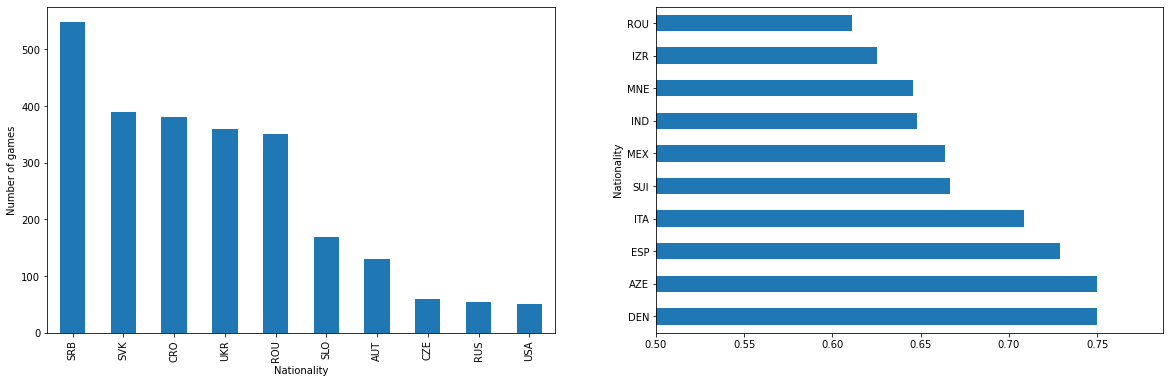

In [24]:
## Performance and number of games by nationality 
def nationality_games_and_performance(df):
    
    fig, axs = plt.subplots(1,2)
    
    nat_games=df.groupby('Nationality_home').size().sort_values(ascending=False)+df.groupby('Nationality_away').size().sort_values(ascending=False)
    nat_games.sort_values(ascending=False).dropna().iloc[1:].head(10).plot.bar(figsize=(20,6), ax=axs[0], xlabel='Nationality', ylabel='Number of games') # we drop the first row (as its obviously hungary)

    a = (df.groupby('Nationality_away')['Result_away'].mean() + df.groupby('Nationality_home')['Result_home'].mean())/2
    a.sort_values(ascending=False).dropna().head(10).plot.barh(figsize=(20,6), ax=axs[1], xlim=0.5, xlabel='Nationality', ylabel='Average points per game')
    
    
nationality_games_and_performance(df)

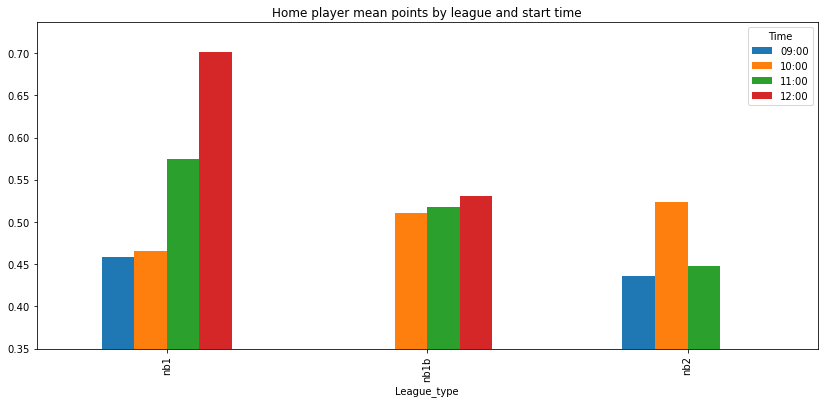

In [25]:
def add_league_type(df):
    df['League_type'] = df['League'].apply(lambda x: x[0:4])
    df['League_type'] = df['League_type'].apply(lambda x: x[0:3] if x != 'nb1b' else x)
    df['League_type']
    return df

df = add_league_type(df)

def start_time_analysis(df):
    pd.pivot_table(df[df.Time != '15:00'], index=['League_type', 'Time'],values=['Result_home'], aggfunc=np.mean)
    pd.pivot_table(df[df.Time != '15:00'], index=['League_type', 'Time'],values=['Result_home'], aggfunc=np.mean)['Result_home'].unstack().plot.bar(figsize=(14,6), ylim=0.35, title='Home player mean points by league and start time')
 
start_time_analysis(df)

<AxesSubplot:title={'center':'Number of games by league by start time on log scale'}, xlabel='League_type'>

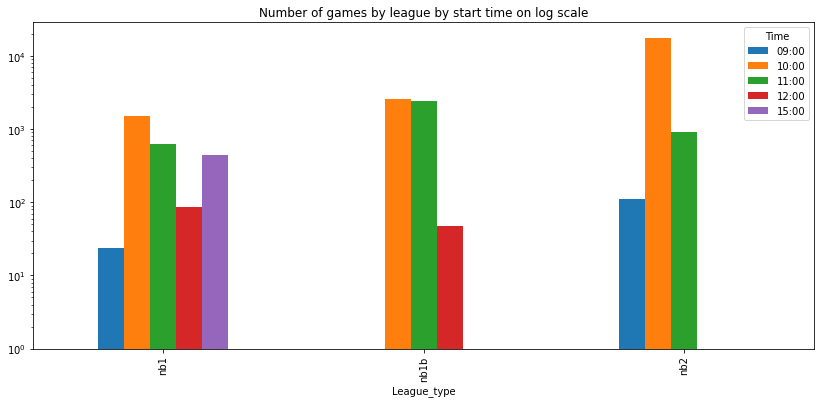

In [26]:
df.groupby(['League_type', 'Time']).size().unstack().plot.bar(figsize=(14,6), log=True, title='Number of games by league by start time on log scale')

<AxesSubplot:xlabel='Time'>

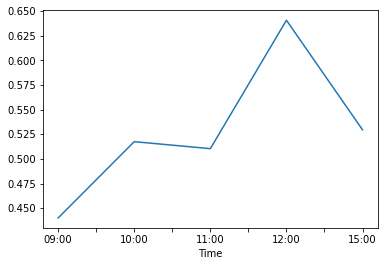

In [27]:
# youth player performance with respect to start time
df.groupby('Time')['Result_home'].mean().plot()

<AxesSubplot:title={'center':'Female player performance on the road at a given start time'}, xlabel='Time'>

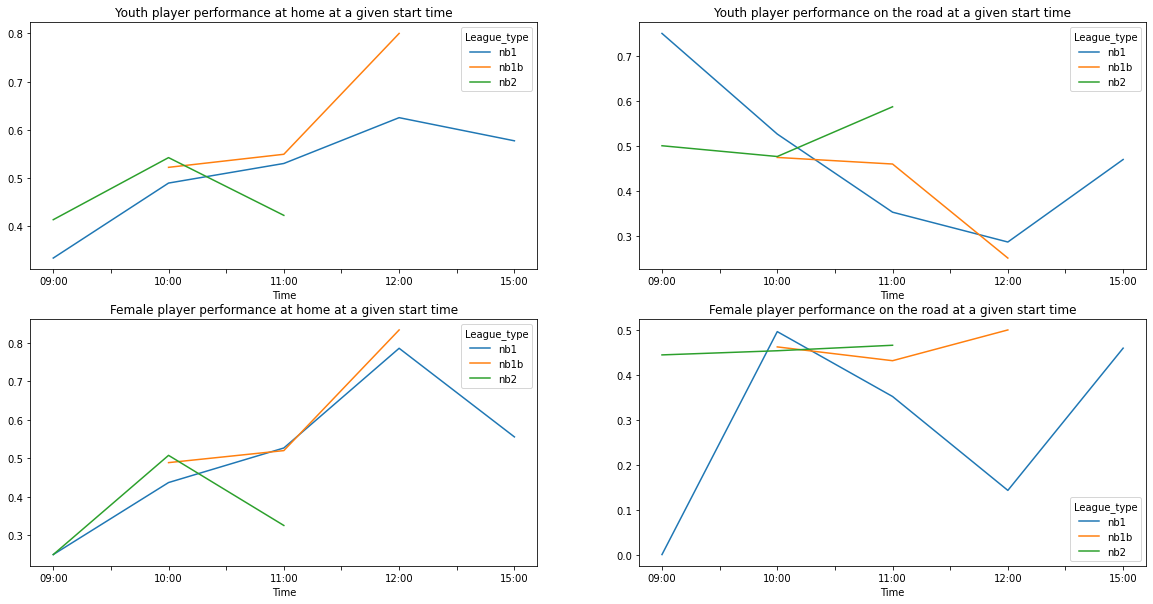

In [28]:
fig, axs = plt.subplots(2,2)
df[df['Youth_home']==1].groupby(['Time', 'League_type'])['Result_home'].mean().unstack().plot(ax=axs[0,0], figsize=(20,10), title='Youth player performance at home at a given start time')
df[df['Youth_away']==1].groupby(['Time', 'League_type'])['Result_away'].mean().unstack().plot(ax=axs[0,1], figsize=(20,10), title='Youth player performance on the road at a given start time')
df[df['Female_home']==1].groupby(['Time', 'League_type'])['Result_home'].mean().unstack().plot(ax = axs[1,0], figsize=(20,10), title='Female player performance at home at a given start time')
df[df['Female_away']==1].groupby(['Time', 'League_type'])['Result_away'].mean().unstack().plot(ax = axs[1,1], figsize=(20,10), title='Female player performance on the road at a given start time')

In [29]:
print(df[df['Youth_away']==1]['Result_away'].mean(), df[df['Youth_home']==1]['Result_home'].mean())

0.4785548686244204 0.5346085584697299


In [30]:
print(df[df['Female_away']==1]['Result_away'].mean(), df[df['Female_home']==1]['Result_home'].mean())

0.450402144772118 0.4983617300131062


In [31]:
print(df[(df['Female_away']==0) & (df['Youth_away']==0)]['Result_away'].mean(), df[(df['Female_home']==0) & (df['Youth_home']==0)]['Result_home'].mean())

0.4849651721769842 0.5138148564721992


In [43]:
df.groupby('AgeBin_home')['Result_home'].mean()

AgeBin_home
1.0    0.540261
2.0    0.527660
3.0    0.538874
4.0    0.532770
5.0    0.489198
6.0    0.449517
Name: Result_home, dtype: float64

In [44]:
df.groupby('AgeBin_away')['Result_away'].mean()

AgeBin_away
1.0    0.487740
2.0    0.511026
3.0    0.526909
4.0    0.502277
5.0    0.449224
6.0    0.413737
Name: Result_away, dtype: float64

In [46]:
df[df['Player away']=='Szukics Ádám']['Age_away']

674      16.0
796      16.0
1035     16.0
4765     16.0
4908     16.0
5338     16.0
6455     17.0
6588     17.0
6870     17.0
12937    18.0
18214    19.0
18608    19.0
18738    19.0
22162    19.0
24203    20.0
24371    20.0
24523    20.0
Name: Age_away, dtype: float64

In [38]:
## TODO: 

# AgeBin-ek egymás ellen hogyan teljesítenek 
# AgeBin idegen / otthon 
# AgeBin vs Female / Youth 
# az otthon/idegen statokat 2d-s scatterplotra (jobb felso a "cel")
# performance :)) -> best performing players
# feher/fekete mennyit szamit (femalenek, youthnak, agebinnek, titlenek)
# title vs female / youth 
# jatekosokat elo alapjan bin-be tenni ... 
# halis statisztikák :) 
# ligankent/csapatonkent legtobb ifi/no
# totalgames? kik jatszanak sokat? 
# -->> "Mozgo teljesitmeny" : megeri e jatszatni azokat, akiknek nem ment jol a korabbi fordulokban !


count    26353.000000
mean        39.448298
std         18.579895
min          7.000000
25%         22.000000
50%         39.000000
75%         55.000000
max         89.000000
Name: Age_home, dtype: float64

In [ ]:
import seaborn as sns

#fig, ax = plt.subplots(figsize=(20,26))
#plt.figure(figsize = (20,26))
#sns.heatmap(df.corr())

In [ ]:
#corr_plot = df.corr().loc[:,'Result_home'].sort_values(ascending=False).reset_index()
#corr_plot.head(15)

In [ ]:
#sns.pairplot(df.sample(1000))